In [26]:
import torch
import os
import numpy as np

# Define configurations
MODELS = [
    # "meta-llama/Llama-3.2-1B-Instruct",
    "EleutherAI/pythia-2.8b", 
    "openai-community/gpt2-large",
    "meta-llama/Llama-2-7b-hf",
    "mistralai/Mistral-7B-v0.1",
    # "meta-llama/Llama-3.1-8B"
]

# Define settings
SETTINGS = [
            # "numerics_PCA", 
            # "numerics_PLS", 
            "symbols_PCA", 
            # "symbols_PLS"
            ]

# Number of runs
RUNS = 3

# Directory containing the .pth files
DATA_DIR = "checkpoints"  # Update this with the correct path

# Dictionary to store loaded models
loaded_models = {}

for model in MODELS:
    model_name = model.replace("/", "_")  # Extract model identifier
    loaded_models[model_name] = {}

    for setting in SETTINGS:
        loaded_models[model_name][setting] = []

        for run in range(1, RUNS + 1):
            filename = f"{model_name}_{setting}_1_4_40"
            if run > 1:
                filename += f"_R{run}"
            filename += ".pth"
            file_path = os.path.join(DATA_DIR, filename)

            if os.path.exists(file_path):
                loaded_models[model_name][setting].append(torch.load(file_path, weights_only=False))
            else:
                print(f"Warning: {file_path} not found.")

# Dictionary to store processed results
processed_models = {}

for model_name, settings in loaded_models.items():
    processed_models[model_name] = {}

    for setting, runs in settings.items():
        processed_models[model_name][setting] = {}

        for layer in runs[0]:  # Assume all runs have the same structure
            processed_models[model_name][setting][layer] = {}

            # Preserve "answers"
            processed_models[model_name][setting][layer]["answers"] = runs[0][layer]["answers"]

            # Process hidden states
            processed_models[model_name][setting][layer]["hidden_states"] = {}
            for group in runs[0][layer]["hidden_states"].keys():
                all_runs = np.array([run[layer]["hidden_states"][group] for run in runs])
                processed_models[model_name][setting][layer]["hidden_states"][group] = {
                    "mean": np.mean(all_runs, axis=0),
                    "std": np.std(all_runs, axis=0)
                }

            # Process metrics
            processed_models[model_name][setting][layer]["metrics"] = {}
            for metric in ["Explained_variance", "monotonicity_metric", "sublinearity_metric"]:
                metric_values = np.abs(np.array([run[layer][metric] for run in runs]))
                processed_models[model_name][setting][layer]["metrics"][metric] = {
                    "mean": np.mean(metric_values),
                    "std": np.std(metric_values)
                }

print("Processed models successfully!")


Processed models successfully!


In [18]:
# Find the layer with the highest explained variance
for model_name, settings in processed_models.items():
    for setting, layers in settings.items():
        max_var_layer = None
        max_explained_variance = -float("inf")

        # Find the layer with max explained variance
        for layer, data in layers.items():
            if layer == 0:continue
            explained_var_mean = data["metrics"]["Explained_variance"]["mean"]
            if explained_var_mean > max_explained_variance:
                max_explained_variance = explained_var_mean
                max_var_layer = layer

        # Print the metrics of the selected layer
        if max_var_layer:
            print(f"Model: {model_name}, Setting: {setting}")
            print(f"Layer with max explained variance: {max_var_layer}")
            print("Metrics:")
            for metric, values in layers[max_var_layer]["metrics"].items():
                print(f"  {metric}: Mean = {values['mean']:.4f}, Std = {values['std']:.4f}")
            print("=" * 50)


Model: EleutherAI_pythia-2.8b, Setting: numerics_PCA
Layer with max explained variance: 8
Metrics:
  Explained_variance: Mean = 0.3089, Std = 0.0119
  monotonicity_metric: Mean = 0.9392, Std = 0.0076
  sublinearity_metric: Mean = 0.5441, Std = 0.0086
Model: openai-community_gpt2-large, Setting: numerics_PCA
Layer with max explained variance: 18
Metrics:
  Explained_variance: Mean = 0.3196, Std = 0.0015
  monotonicity_metric: Mean = 0.9469, Std = 0.0047
  sublinearity_metric: Mean = 0.5777, Std = 0.0165
Model: meta-llama_Llama-2-7b-hf, Setting: numerics_PCA
Layer with max explained variance: 3
Metrics:
  Explained_variance: Mean = 0.6037, Std = 0.0061
  monotonicity_metric: Mean = 0.9744, Std = 0.0041
  sublinearity_metric: Mean = 0.8331, Std = 0.0642
Model: mistralai_Mistral-7B-v0.1, Setting: numerics_PCA
Layer with max explained variance: 3
Metrics:
  Explained_variance: Mean = 0.4431, Std = 0.0000
  monotonicity_metric: Mean = 0.9613, Std = 0.0000
  sublinearity_metric: Mean = 1.0483

Model: meta-llama_Llama-2-7b-hf, Setting: numerics_PCA
Layer with max explained variance: 3
(160,) (160,)
Model: meta-llama_Llama-2-7b-hf, Setting: symbols_PCA
Layer with max explained variance: 1
(160,) (160,)


<>:49: SyntaxWarning: invalid escape sequence '\l'
<>:49: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_880795/2803911493.py:49: SyntaxWarning: invalid escape sequence '\l'
  axs[idx].set_xlabel('$\log_{10}$(x)', fontsize=26)
/tmp/ipykernel_880795/2803911493.py:44: RuntimeWarning: divide by zero encountered in log10
  np.log10(all_answers), projections, c=new_array, cmap='viridis', alpha=0.7, s=100  # Increased marker size


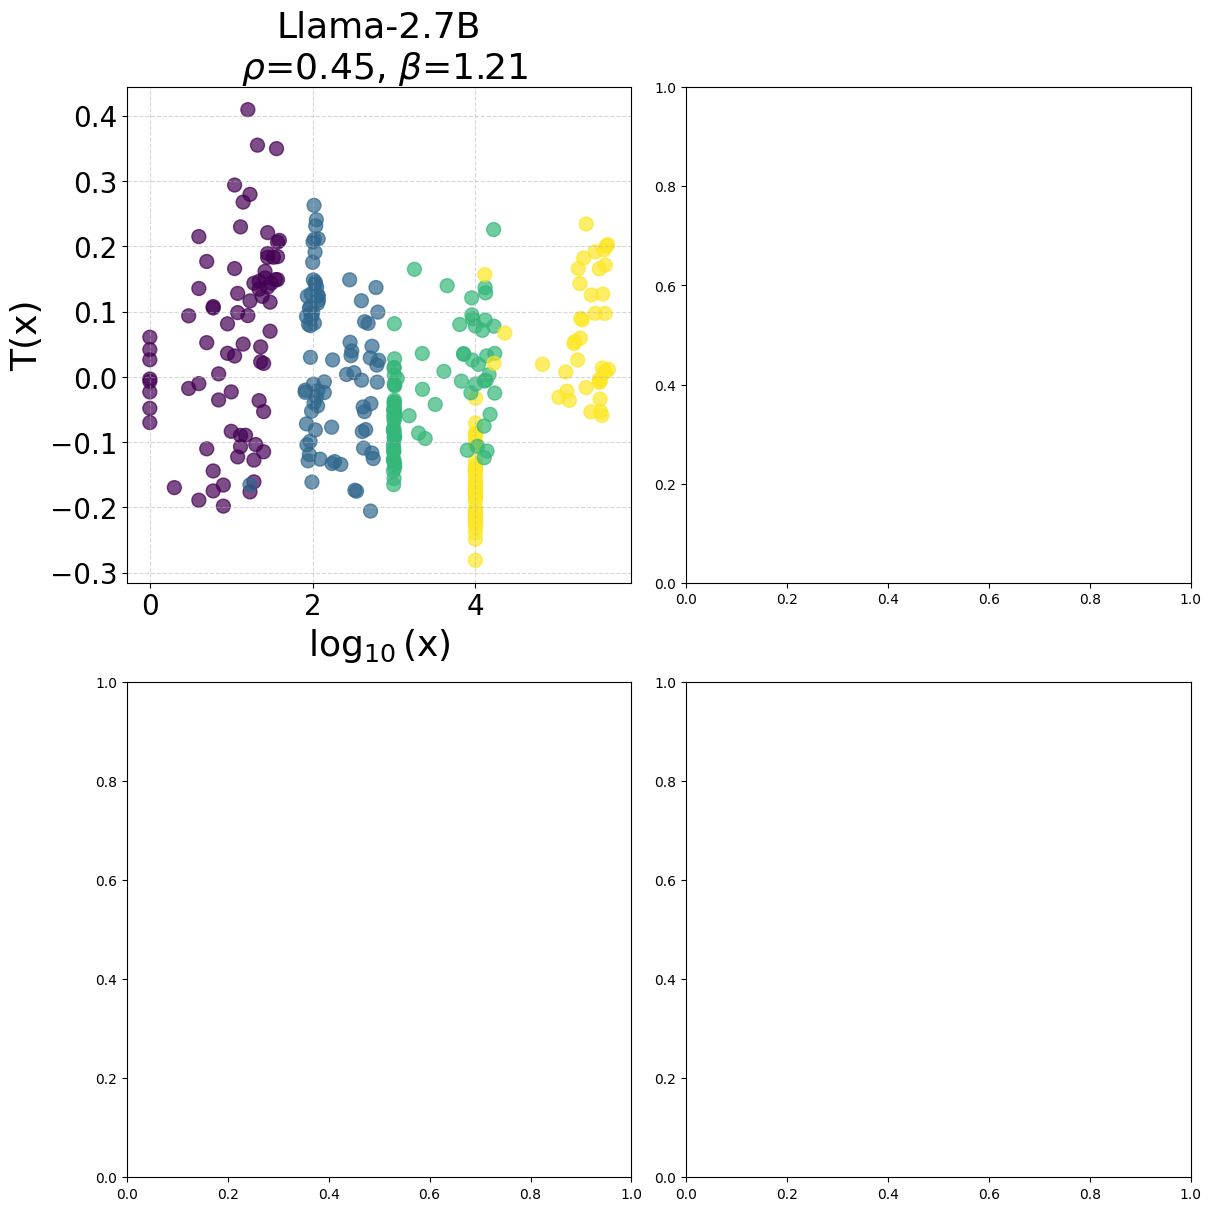

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Set up figure and axes for 3x2 grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), constrained_layout=True)
axs = axs.flatten()  # Flatten for easier indexing

# Iterate over models and plot the highest explained variance layer
for idx, (model_name, settings) in enumerate(processed_models.items()):
    for setting, layers in settings.items():
        max_var_layer = None
        max_explained_variance = -float("inf")

        # Find the layer with max explained variance, skipping layer 0
        for layer, data in layers.items():
            if int(layer) == 0:  # Ensure layer 0 is skipped
                continue
            explained_var_mean = data["metrics"]["Explained_variance"]["mean"]
            if explained_var_mean > max_explained_variance:
                max_explained_variance = explained_var_mean
                max_var_layer = layer

        # Print the metrics of the selected layer
        if max_var_layer:
            print(f"Model: {model_name}, Setting: {setting}")
            print(f"Layer with max explained variance: {max_var_layer}")

            # Prepare data for plotting
            all_answers = []
            projections = []
            new_array = []

            data = layers[max_var_layer]
            for group_id, group_data in data['answers'].items():
                all_answers.extend(group_data)
                projections.extend(data['hidden_states'][group_id]['mean'])  # Use mean hidden state
                new_array.extend([int(group_id)] * len(group_data))

            all_answers = np.array(all_answers, dtype=float)
            projections = np.array(projections).squeeze()
            print(all_answers.shape,projections.shape)
            # Plot for the current model
            sc = axs[idx].scatter(
                np.log10(all_answers), projections, c=new_array, cmap='viridis', alpha=0.7, s=100  # Increased marker size
            )
            
            model_name_short = model_name.replace("openai-community_gpt2-large", "GPT2-L").replace("meta-llama_Llama-2-7b-hf", "Llama-2.7B").replace("EleutherAI_pythia-2.8b", "Pythia-2.8B").replace("mistralai_Mistral-7B-v0.1", "Mistral-7B")
            axs[idx].set_title(f'{model_name_short}\n $\\rho$={data["metrics"]["monotonicity_metric"]["mean"]:.2f}, $\\beta$={data["metrics"]["sublinearity_metric"]["mean"]:.2f}', fontsize=26)
            axs[idx].set_xlabel('$\log_{10}$(x)', fontsize=26)
            axs[idx].set_ylabel('T(x)', fontsize=26)
            axs[idx].tick_params(axis='both', labelsize=20)
            axs[idx].grid(True, linestyle="--", alpha=0.5)


# Adjust layout and show
# plt.suptitle("Hidden State Projections for Layers with Highest Explained Variance", fontsize=18)
import os
if not os.path.exists('checkpoints/plots'):
    os.makedirs('checkpoints/plots')
# plt.savefig('checkpoints/plots/plot2.pdf', format='pdf')







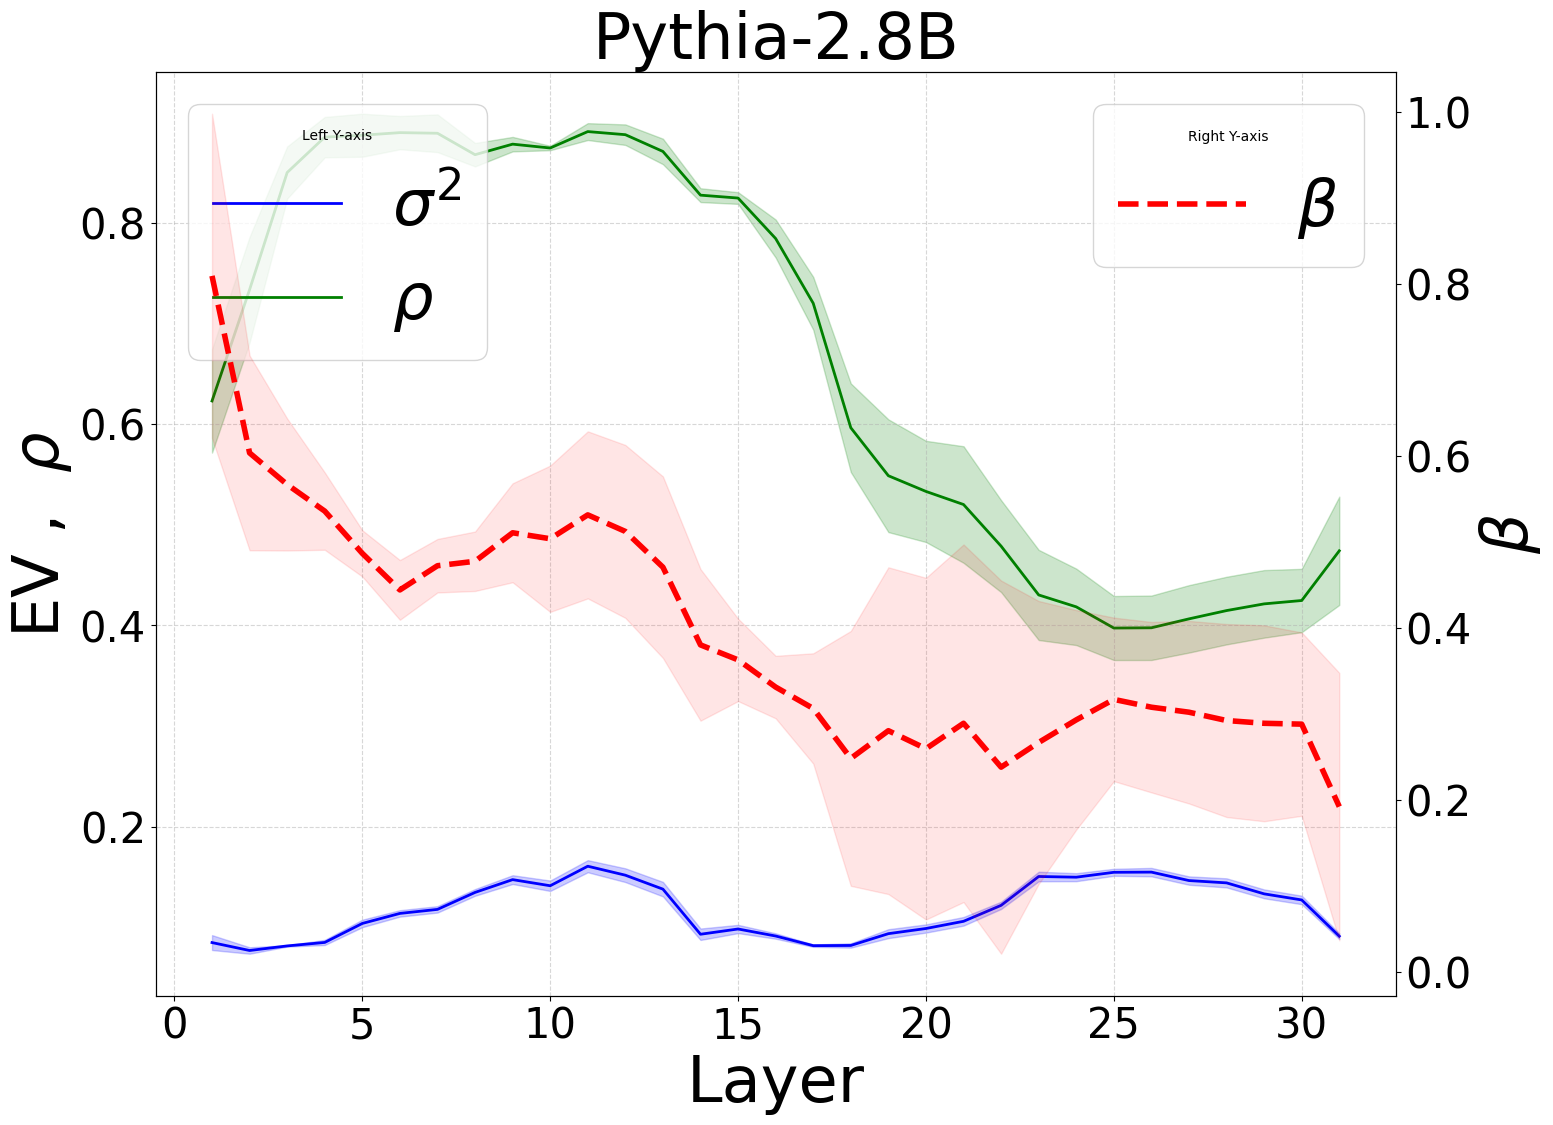

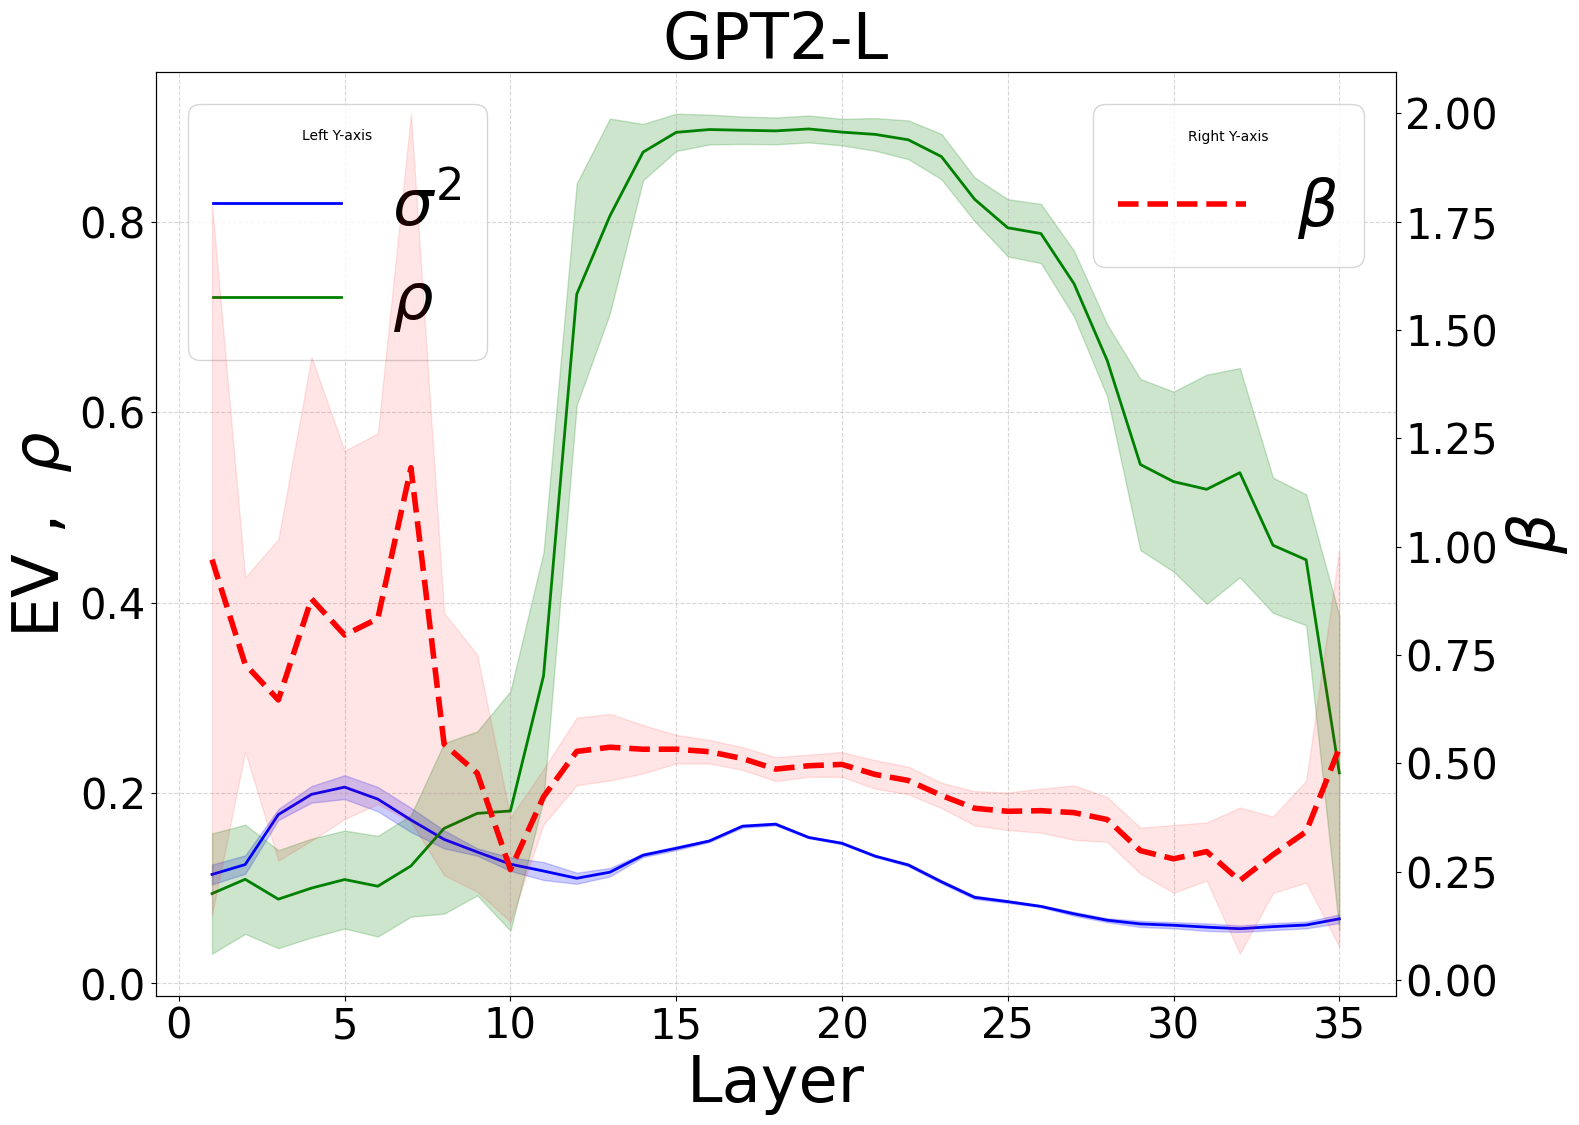

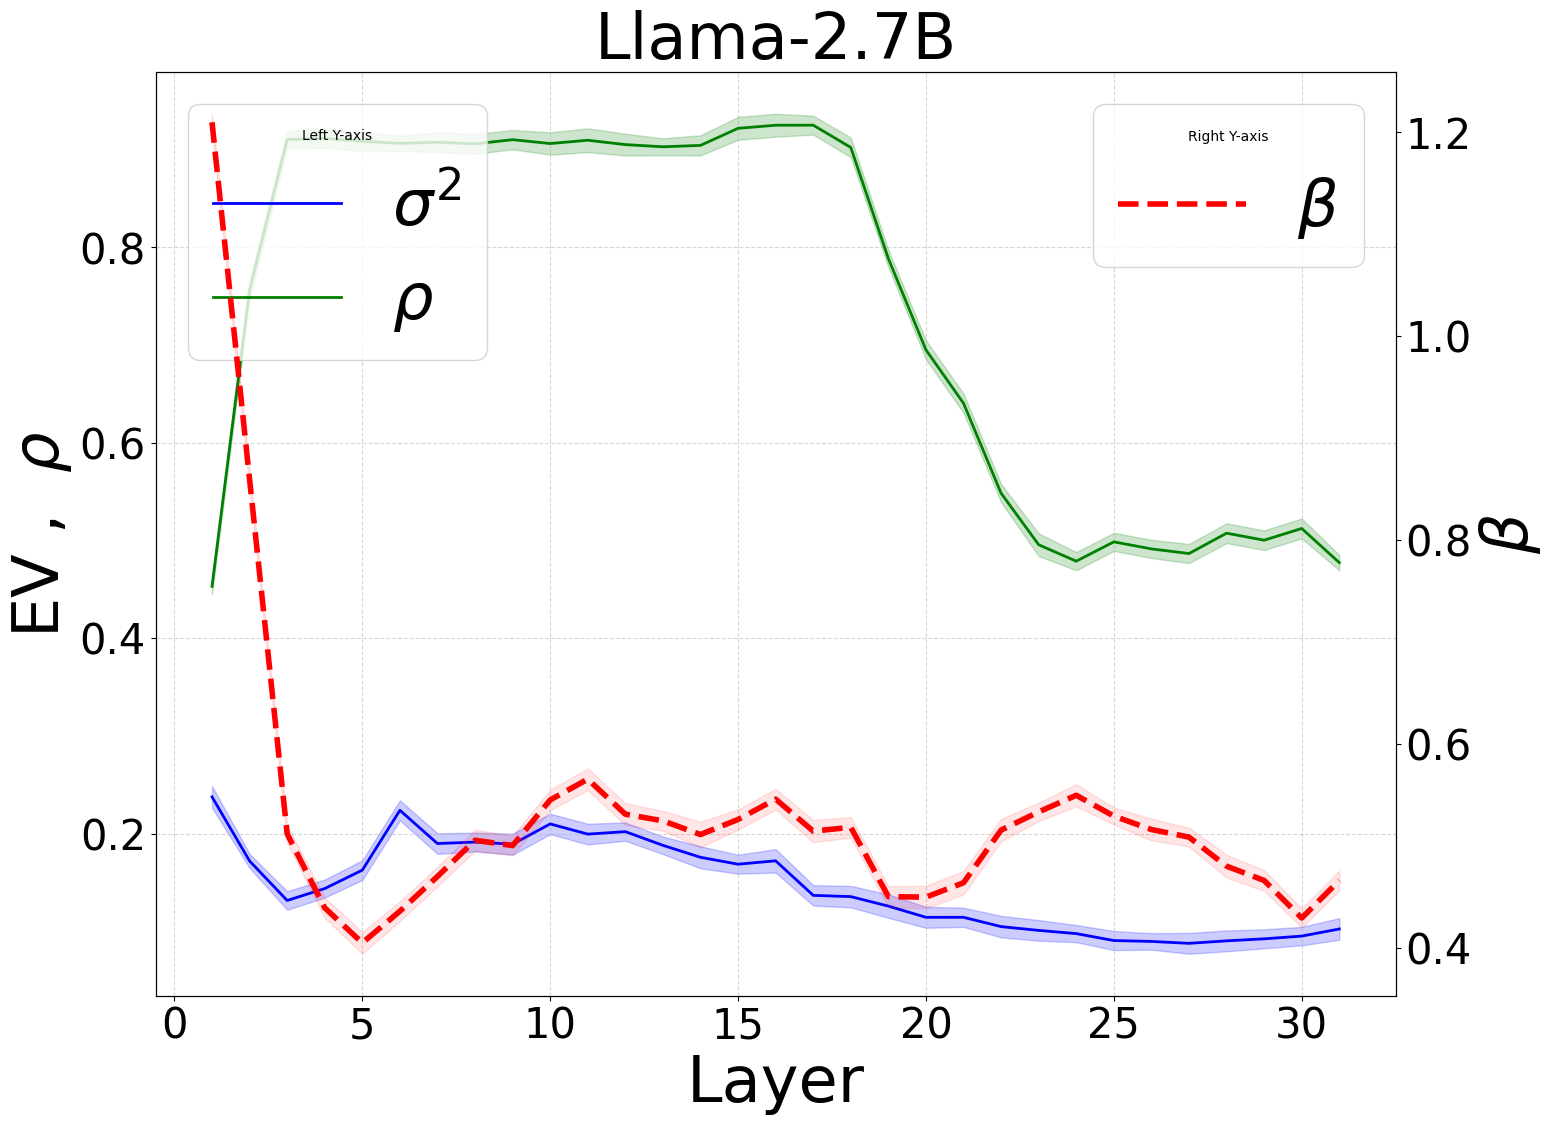

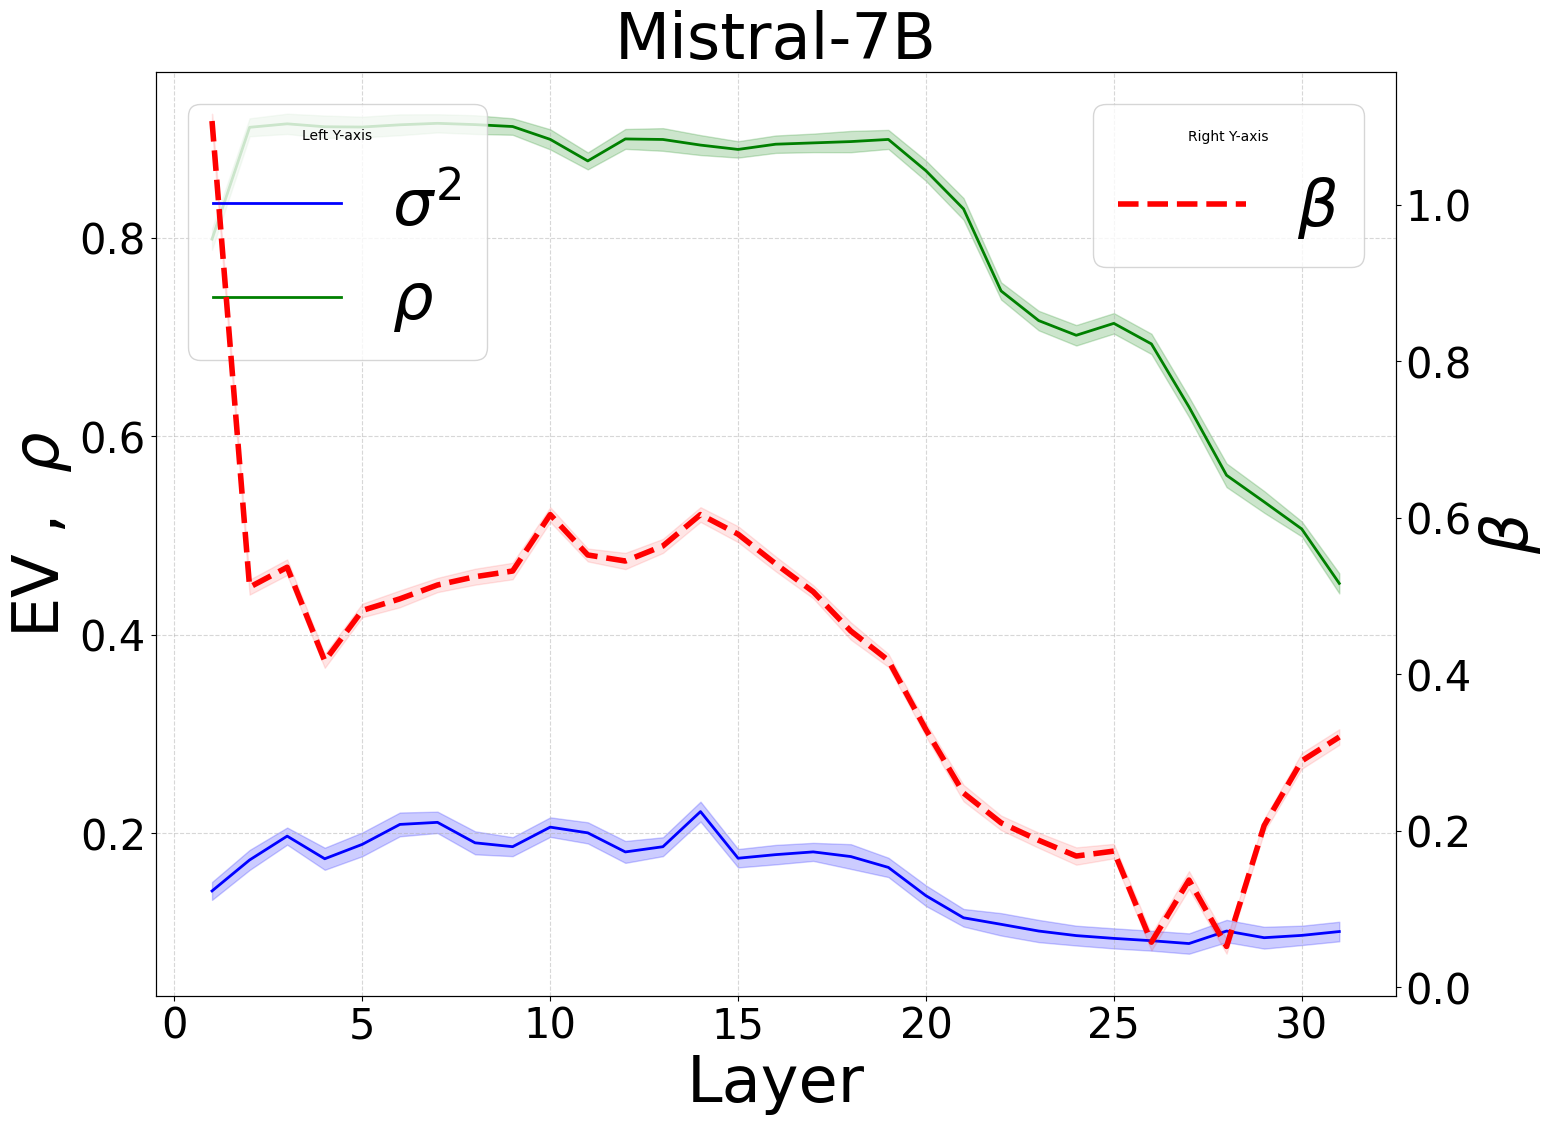

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define the metrics to plot
left_y_metrics = {
    "Explained_variance": r"$\sigma^2$",  # Explained Variance → EV
    "monotonicity_metric": r"$\rho$",  # Monotonicity → ρ (rho)
}
right_y_metric = "sublinearity_metric"  # Sublinearity → β (beta)
right_y_label = r"$\beta$"

colors = {"Explained_variance": "b", "monotonicity_metric": "g", "sublinearity_metric": "r"}  # Color mapping

# Model name replacements for shorter titles
model_name_map = {
    "openai-community_gpt2-large": "GPT2-L",
    "meta-llama_Llama-2-7b-hf": "Llama-2.7B",
    "EleutherAI_pythia-2.8b": "Pythia-2.8B",
    "mistralai_Mistral-7B-v0.1": "Mistral-7B",
}

# Iterate over models
for model_name, settings in processed_models.items():
    model_name_short = model_name_map.get(model_name, model_name)  # Use mapped name if available
    
    for setting, layers in settings.items():
        layers_sorted = sorted(layers.keys(), key=int)  # Ensure layers are sorted numerically

        # Initialize figure
        fig, ax1 = plt.subplots(figsize=(16, 12))
        ax2 = ax1.twinx()  # Create a second y-axis

        # Iterate over left-axis metrics (Explained Variance & Monotonicity)
        for metric, label in left_y_metrics.items():
            means = []
            stds = []
            layer_indices = []

            # Collect mean and std values for all layers
            for layer in layers_sorted:
                if int(layer) == 0:  # Skip layer 0
                    continue
                means.append(layers[layer]["metrics"][metric]["mean"])
                stds.append(layers[layer]["metrics"][metric]["std"])
                layer_indices.append(int(layer))

            # Convert to numpy arrays
            means = np.array(means)
            stds = np.array(stds)
            layer_indices = np.array(layer_indices)

            # Plot on primary y-axis
            ax1.plot(layer_indices, means, label=label, color=colors[metric], linewidth=2)
            ax1.fill_between(layer_indices, means - stds, means + stds, color=colors[metric], alpha=0.2)

        # Handle right-axis metric (Sublinearity)
        means = []
        stds = []
        layer_indices = []

        for layer in layers_sorted:
            if int(layer) == 0:
                continue
            means.append(layers[layer]["metrics"][right_y_metric]["mean"])
            stds.append(layers[layer]["metrics"][right_y_metric]["std"])
            layer_indices.append(int(layer))

        means = np.array(means)
        stds = np.array(stds)
        layer_indices = np.array(layer_indices)

        # Plot on secondary y-axis
        ax2.plot(layer_indices, means, label=right_y_label, color=colors[right_y_metric], linewidth=4, linestyle="dashed")
        ax2.fill_between(layer_indices, means - stds, means + stds, color=colors[right_y_metric], alpha=0.1)

        # Formatting
        ax1.set_title(f"{model_name_short}", fontsize=46)
        ax1.set_xlabel("Layer", fontsize=46)
        ax1.set_ylabel(r"EV ,  $\rho$", fontsize=46, color="black")
        ax2.set_ylabel(right_y_label, fontsize=46, color="black")

        ax1.tick_params(axis="y", labelcolor="black")
        ax2.tick_params(axis="y", labelcolor="black")

        ax1.tick_params(axis="x", labelsize=30)
        ax1.tick_params(axis="y", labelsize=30)
        ax2.tick_params(axis="y", labelsize=30)

        # Custom legends
        ax1.legend(loc="upper left", fontsize=46, title="Left Y-axis")
        ax2.legend(loc="upper right", fontsize=46, title="Right Y-axis")

        ax1.grid(True, linestyle="--", alpha=0.5)
        # Save the figure
        plt.savefig(f"checkpoints/plots/{model_name_short}_symbols.pdf")
        # Show plot for the current model
        plt.show()


# Ablation study on number of examples in context and number of samples in groups

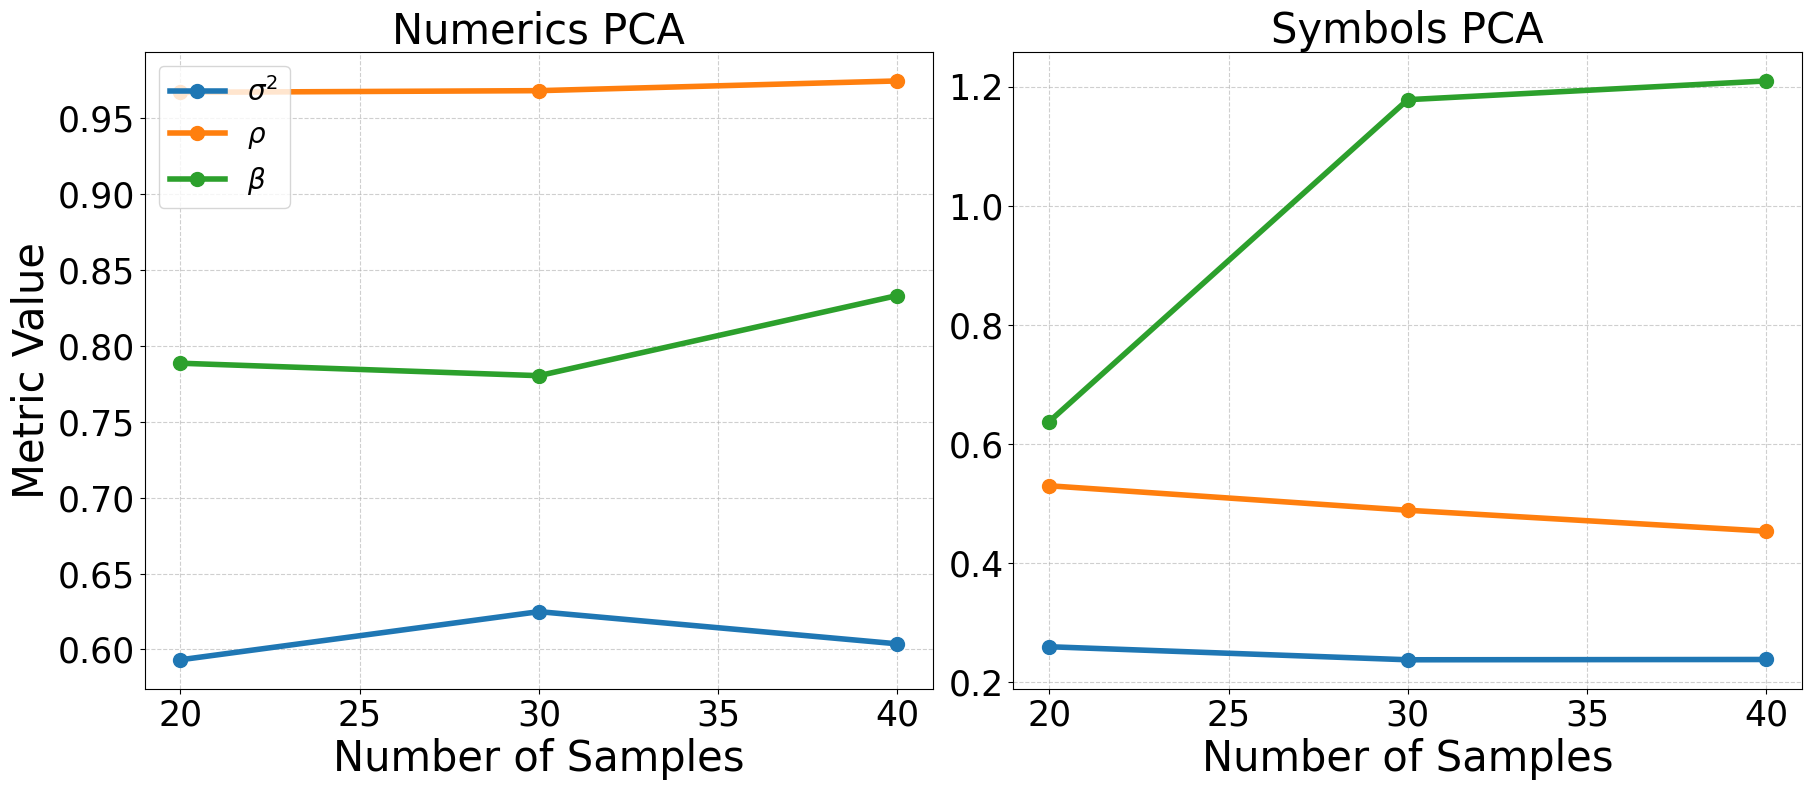

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
samples = [20, 30, 40]
numerics_pca = {
    r"$\sigma^2$": [0.5932, 0.6249, 0.6037],
    r"$\rho$": [0.9669, 0.9680, 0.9744],
    r"$\beta$": [0.7885, 0.7803, 0.8331]
}
symbols_pca = {
    r"$\sigma^2$": [0.2589, 0.2370, 0.2375],
    r"$\rho$": [0.5293, 0.4882, 0.4530],
    r"$\beta$": [0.6372, 1.1779, 1.2094]
}

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Increase figure size

def plot_metrics(ax, data, title,show_ylabel=True):
    for metric, values in data.items():
        ax.plot(samples, values, marker='o', markersize=10, label=metric, linewidth=4)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel("Number of Samples", fontsize=30)
    if show_ylabel:
        ax.set_ylabel("Metric Value", fontsize=30)
        ax.legend(fontsize=20, loc='upper left')
    ax.tick_params(axis='both', labelsize=25)
   
    ax.grid(True, linestyle='--', alpha=0.6)

# Plot both settings
plot_metrics(axes[0], numerics_pca, "Numerics PCA")
plot_metrics(axes[1], symbols_pca, "Symbols PCA", show_ylabel=False)
plt.savefig('checkpoints/plots/samples_4.pdf')

plt.tight_layout()
plt.show()


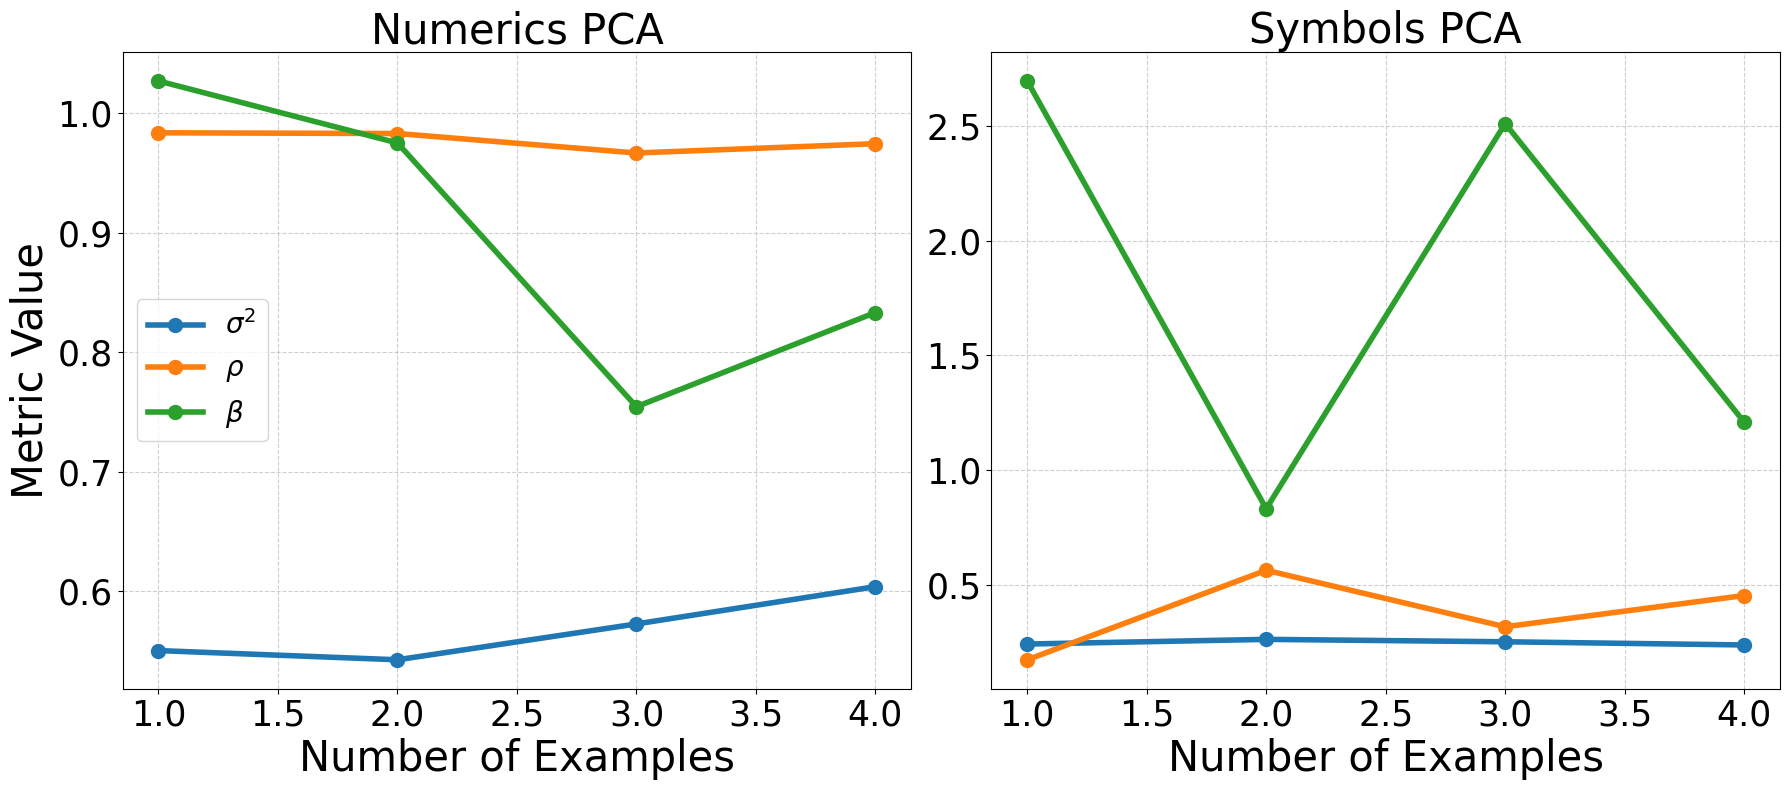

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
samples = [1, 2, 3,4]
numerics_pca = {
    r"$\sigma^2$": [0.5502, 0.5425, 0.5725,0.6037],
    r"$\rho$": [0.9835,0.9829, 0.9666,0.9744],
    r"$\beta$": [1.0269, 0.9750, 0.7543,0.8331]
}
symbols_pca = {
    r"$\sigma^2$": [0.2414, 0.2618, 0.2513,0.2375],
    r"$\rho$": [0.1728, 0.5631, 0.3168,0.4530],
    r"$\beta$": [2.6970,0.8317, 2.5112, 1.2094]
}

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 8))  # Increase figure size

def plot_metrics(ax, data, title, show_ylabel=True):
    for metric, values in data.items():
        ax.plot(samples, values, marker='o', markersize=10, label=metric, linewidth=4)
    ax.set_title(title, fontsize=30)
    ax.set_xlabel("Number of Examples", fontsize=30)
    if show_ylabel:
        ax.set_ylabel("Metric Value", fontsize=30)
        ax.legend(fontsize=20, loc='center left')
    ax.tick_params(axis='both', labelsize=25)

    ax.grid(True, linestyle='--', alpha=0.6)

# Plot both settings
plot_metrics(axes[0], numerics_pca, "Numerics PCA")
plot_metrics(axes[1], symbols_pca, "Symbols PCA", show_ylabel=False)
plt.savefig('checkpoints/plots/examples_40.pdf')

plt.tight_layout()
plt.show()

# Experiemnts 2: population and birthyear 

In [1]:
import os
import torch

# Define the directory
directory = 'checkpoints/Exp2/results'

# Define the models and file extensions
models = [
            # 'Llama-2-7b', 
          'Llama-3.2-1B'
          ]
file_extensions = [
                    # '_population_PLS_1.pt', 
                #    '_population_PLS_2.pt', 
                   '_birth_PLS_1.pt', 
                #    '_birth_PLS_2.pt'
                   ]

# Load the files
for model in models:
    for file_extension in file_extensions:
        file_name = f'{model}{file_extension}'
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            try:
                arr = torch.load(file_path,weights_only=False)
                print(f'Loaded file: {file_name}')
            except Exception as e:
                print(f'Error loading file: {file_name}, {str(e)}')
        else:
            print(f'File not found: {file_name}')


Loaded file: Llama-3.2-1B_birth_PLS_1.pt


/home/bhaskar_mukhoty/miniconda3/envs/mamba/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PLSRegression from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
# find number of layers
layers = len(arr)
print('number of layer in model:',layers)
# load answers 
import pandas as pd
answers = pd.read_csv('/home/bhaskar_mukhoty/Hilal/natural_log/checkpoints/Exp2/results/population.csv')
answers = torch.from_numpy(answers['value'].to_numpy().astype(float))
for i in range(layers):
    arr[i]['hidden_states'] = arr[i].pop('states')
    arr[i]['answers'] = answers

# create the groups of hidden state (we need the answer here)


number of layer in model: 16


In [3]:
# Group the values in hidden states and answers
for i in range(layers):
    hidden_states = arr[i]['hidden_states']
    answers = arr[i]['answers']
    # Initialize new hidden states and answers for grouping
    new_hidden_states = {}
    new_answers = {}
    # Sort the answers
    sorted_answers = torch.sort(answers).values
    # Calculate the quartiles
    q1 = torch.quantile(sorted_answers, 0.25)
    q2 = torch.quantile(sorted_answers, 0.5)
    q3 = torch.quantile(sorted_answers, 0.75)
    # Group the values in hidden states and answers
    for group in range(1, 5):
        # Find the indices of the values in the current quartile
        if group == 1:
            indices = torch.where(answers <= q1)
        elif group == 2:
            indices = torch.where((answers > q1) & (answers <= q2))
        elif group == 3:
            indices = torch.where((answers > q2) & (answers <= q3))
        else:
            indices = torch.where(answers > q3)
        # Group the values in hidden states and answers
        new_hidden_states[group] = hidden_states[indices]
        new_answers[group] = answers[indices]
    # Update the hidden states and answers in arr with the new grouped values
    arr[i]['hidden_states'] = new_hidden_states
    arr[i]['answers'] = new_answers



In [4]:
from utils.compute_utils import analyze_transformed_hidden_states
new_array = analyze_transformed_hidden_states(arr)

Layer 0 -EV: [0.0],  M²: nan, SM: 1.000
Layer 1 -EV: [0.15703736753109931],  M²: 0.017, SM: 0.964
Layer 2 -EV: [0.20745701117658588],  M²: 0.007, SM: 1.690
Layer 3 -EV: [0.2166792426012767],  M²: -0.001, SM: 1.151
Layer 4 -EV: [0.3232234665694148],  M²: -0.006, SM: 1.298
Layer 5 -EV: [0.4005078644808655],  M²: 0.015, SM: 1.299
Layer 6 -EV: [0.4359663443861971],  M²: 0.023, SM: 1.156
Layer 7 -EV: [0.4292001078460511],  M²: -0.030, SM: 0.968
Layer 8 -EV: [0.4413559609237999],  M²: 0.026, SM: 0.990
Layer 9 -EV: [0.4729295060315877],  M²: -0.025, SM: 0.907
Layer 10 -EV: [0.521038071148253],  M²: 0.022, SM: 0.876
Layer 11 -EV: [0.5311076806285528],  M²: -0.027, SM: 0.803
Layer 12 -EV: [0.6057802425352339],  M²: -0.028, SM: 0.928
Layer 13 -EV: [0.5817899032432872],  M²: -0.028, SM: 0.964
Layer 14 -EV: [0.5716646371867133],  M²: -0.030, SM: 0.967
Layer 15 -EV: [0.5689214345222963],  M²: -0.032, SM: 0.927


# EXP2 PCA

In [33]:
import os
import torch

# Define the directory
directory = 'checkpoints/Exp2/results/PCA'

# Define the models and file extensions
models = [
            '1B', 
            # '8B'
          ]
file_extensions = [
                    # '_birth.pth', 
                   '_population.pth', 
                   ]
# Load the files
for model in models:
    for file_extension in file_extensions:
        file_name = f'{model}{file_extension}'
        file_path = os.path.join(directory, file_name)
        print(file_path)
        if os.path.exists(file_path):
            try:
                arr = torch.load(file_path,weights_only=False)
                print(f'Loaded file: {file_name}')
            except Exception as e:
                print(f'Error loading file: {file_name}, {str(e)}')
        else:
            print(f'File not found: {file_name}')


checkpoints/Exp2/results/PCA/8B_population.pth
Loaded file: 8B_population.pth


In [34]:
# find number of layers
layers = len(arr)
print('number of layer in model:',layers)
# load answers 
import pandas as pd
answers = pd.read_csv('/home/bhaskar_mukhoty/Hilal/natural_log/checkpoints/Exp2/results/population.csv')
answers = torch.from_numpy(answers['value'].to_numpy().astype(float))
for i in range(layers):
    arr[i]['hidden_states'] = arr[i].pop('states')
    arr[i]['answers'] = answers[:827]

# create the groups of hidden state (we need the answer here)

number of layer in model: 32


In [35]:
arr[1]['hidden_states'].shape

(827, 1)

In [36]:
# Group the values in hidden states and answers
for i in range(layers):
    hidden_states = arr[i]['hidden_states']
    answers = arr[i]['answers']
    # Initialize new hidden states and answers for grouping
    new_hidden_states = {}
    new_answers = {}
    # Sort the answers
    sorted_answers = torch.sort(answers).values
    # Calculate the quartiles
    q1 = torch.quantile(sorted_answers, 0.25)
    q2 = torch.quantile(sorted_answers, 0.5)
    q3 = torch.quantile(sorted_answers, 0.75)
    # Group the values in hidden states and answers
    for group in range(1, 5):
        # Find the indices of the values in the current quartile
        if group == 1:
            indices = torch.where(answers <= q1)
        elif group == 2:
            indices = torch.where((answers > q1) & (answers <= q2))
        elif group == 3:
            indices = torch.where((answers > q2) & (answers <= q3))
        else:
            indices = torch.where(answers > q3)
        # Group the values in hidden states and answers
        new_hidden_states[group] = hidden_states[indices]
        new_answers[group] = answers[indices]
    # Update the hidden states and answers in arr with the new grouped values
    arr[i]['hidden_states'] = new_hidden_states
    arr[i]['answers'] = new_answers



In [37]:
from utils.compute_utils import analyze_transformed_hidden_states
new_array = analyze_transformed_hidden_states(arr)

Layer 0 -EV: [nan],  M²: nan, SM: 1.000
Layer 1 -EV: [0.18504758],  M²: -0.010, SM: 1.514
Layer 2 -EV: [0.16127053],  M²: -0.026, SM: 3.902
Layer 3 -EV: [0.19014997],  M²: 0.014, SM: 3.885
Layer 4 -EV: [0.19076168],  M²: -0.019, SM: 1.670
Layer 5 -EV: [0.18636121],  M²: 0.020, SM: 1.113
Layer 6 -EV: [0.20428651],  M²: -0.019, SM: 1.414
Layer 7 -EV: [0.21289504],  M²: -0.010, SM: 1.439
Layer 8 -EV: [0.2281691],  M²: -0.014, SM: 2.128
Layer 9 -EV: [0.22481178],  M²: -0.014, SM: 1.809
Layer 10 -EV: [0.23875415],  M²: -0.014, SM: 1.641
Layer 11 -EV: [0.24091551],  M²: 0.015, SM: 1.546
Layer 12 -EV: [0.23516421],  M²: -0.015, SM: 1.606
Layer 13 -EV: [0.22411002],  M²: -0.016, SM: 1.699
Layer 14 -EV: [0.21794508],  M²: -0.013, SM: 1.583
Layer 15 -EV: [0.20253201],  M²: -0.014, SM: 1.571
Layer 16 -EV: [0.21423762],  M²: -0.014, SM: 1.545
Layer 17 -EV: [0.20883505],  M²: 0.012, SM: 1.414
Layer 18 -EV: [0.19542321],  M²: 0.013, SM: 1.013
Layer 19 -EV: [0.18943117],  M²: -0.016, SM: 1.099
Layer 